In [1]:
from dotenv import load_dotenv
import netCDF4 as nc
import numpy as np
import os
import requests
from terracatalogueclient import Catalogue
from terracatalogueclient.config import CatalogueConfig, CatalogueEnvironment
import pandas as pd
import urllib.request
from urllib.error import HTTPError
import xarray as xr

In [8]:
# Carga las variables de entorno desde el archivo .env
load_dotenv()

# Accede a la contraseña desde las variables de entorno
password = os.getenv('COPERNICUS_PASSWORD')
username = os.getenv('COPERNICUS_USERNAME')

In [4]:

def download_nc_file_with_auth(url, output_file, username, password):
    # Create a password manager with the given username and password
    password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
    password_mgr.add_password(None, url, username, password)
    handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
    opener = urllib.request.build_opener(handler)
    
    try:
        # Open the URL with the configured opener
        response = opener.open(url)
        
        with open(output_file, 'wb') as f:
            f.write(response.read())
        
        print(f"Downloaded {url} to {output_file}")
    except HTTPError as e:
        print(f"Failed to download {url}. Status code: {e.code}, Reason: {e.reason}")



def slice_ds(lat_min, lat_max, lon_min, lon_max, ds):

    lat_min_ds = ds.lat.values.min()
    lat_max_ds = ds.lat.values.max()
    lat_len_ds = len(ds.lat.values)

    lon_min_ds = ds.lon.values.min()
    lon_max_ds = ds.lon.values.max()
    lon_len_ds = len(ds.lon.values)

    lat_coord = np.linspace(lat_max_ds, lat_min_ds, lat_len_ds)
    lon_coord = np.linspace(lon_min_ds, lon_max_ds, lon_len_ds)

    new_lat_min = np.absolute(lat_coord-lat_min).argmin()
    new_lat_max = np.absolute(lat_coord-lat_max).argmin()
    new_lon_min = np.absolute(lon_coord-lon_min).argmin()
    new_lon_max = np.absolute(lon_coord-lon_max).argmin()

    return ds.NDVI[0, new_lat_max:new_lat_min, new_lon_min:new_lon_max]

In [33]:
link_1 = f"https://land.copernicus.vgt.vito.be/manifest/ndvi_v3_1km/manifest_cgls_ndvi_v3_1km_latest.txt" #2020 - 1999
link_2 = f"https://land.copernicus.vgt.vito.be/manifest/ssm_v1_1km/manifest_cgls_ssm_v1_1km_latest.txt" #SSM 2014
link_3 = f"https://land.copernicus.vgt.vito.be/manifest/fapar_v2_1km/manifest_cgls_fapar_v2_1km_latest.txt" #FAPAR 1999 - 202006

link_4 = f"https://land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Indicators/NDVI_1km_V2_LTS/1999/12/21/NDVI-LTS_1999-2017-1221_GLOBE_VGT-PROBAV_V2.2.1/c_gls_NDVI-LTS_1999-2017-1221_GLOBE_VGT-PROBAV_V2.2.1.nc"

links = [link_1, link_2, link_3]
folders = ["nvdi", "ssm", "fapar"]

link_dict = {link:folder for link, folder in zip(links, folders)}

main_data_folder = f"../data"

In [35]:


for link, folder in link_dict.items():

    data_folder = f"{main_data_folder}/{folder}"
    if os.path.exists(data_folder) is False:
        os.mkdir(data_folder)

    response = requests.get(link)

    response.raise_for_status()

    nc_files = response.text.split("\n")

    nc_file = nc_files[0]

    #for nc_file in nc_files:

    filename = nc_file.split("/")[-1]

    if ".nc" in filename:
        output_filename = f'{data_folder}/{filename}'
        download_nc_file_with_auth(nc_file, output_filename, username, password)

        ds = xr.open_dataset(output_filename)

        ds_slice = slice_ds(lat_min=36, lat_max=46, lon_min=-10, lon_max=3, ds=ds)


        ds_slice.to_netcdf(output_filename)

        ds.close()
        ds_slice.to_netcdf(f"{data_folder}/sample.nc")

    break





Downloaded https://land.copernicus.vgt.vito.be/PDF/datapool/Vegetation/Indicators/NDVI_1km_V3/2020/06/21/NDVI_202006210000_GLOBE_PROBAV_V3.0.1/c_gls_NDVI_202006210000_GLOBE_PROBAV_V3.0.1.nc to ../data/nvdi/c_gls_NDVI_202006210000_GLOBE_PROBAV_V3.0.1.nc


PermissionError: [Errno 13] Permission denied: '/home/carlossi/zrive/zrive-ds-4q23-olive/data/nvdi/c_gls_NDVI_202006210000_GLOBE_PROBAV_V3.0.1.nc'

In [15]:
config = CatalogueConfig.from_environment(CatalogueEnvironment.CGLS)
catalogue = Catalogue(config)

In [59]:
import pandas as pd
from itertools import chain
collections = catalogue.get_collections()

rows = []
for c in collections:
    values_list = list(c.properties.values())
    values_list.insert(0, c.id)
    rows.append(values_list)

column_values = list(c.properties.keys())
column_values.insert(0, "Identifier")

df = pd.DataFrame(data = rows, columns = column_values)
# df.style.set_properties(**{'text-align': 'left'})


In [16]:
collections = catalogue.get_collections()
rows = []
for c in collections:
    rows.append([c.id, c.properties['title']])

df_catalogue = pd.DataFrame(data = rows, columns = ['Identifier', 'Description'])
# df_catalogue.to_csv("catalogue_short.txt", sep="\t")

df_catalogue.head()

,Identifier,Description
0,clms_global_albh_1km_v1_10daily_netcdf,Broadband Hemispherical Surface Albedo: global...
1,clms_global_aldh_1km_v1_10daily_netcdf,Broadband Hemispherical Surface Albedo: global...
2,clms_global_ba_300m_v3_daily_netcdf,Burnt Area: global daily (raster 300m)
3,clms_global_ba_300m_v3_monthly_netcdf,Burnt Area: global monthly (raster 300m)
4,clms_global_dmp_1km_v2_10daily_netcdf,Dry Matter Productivity: global 10-daily (rast...


In [18]:
import pandas as pd
import datetime as dt

rows = []
products = catalogue.get_products(
    "clms_global_ndvi_1km_v2_10daily_netcdf",
    start=dt.date(2019, 9, 1),
    end=dt.date(2019, 9, 1),
    bbox = [-10, 36, 3, 46]
)

for product in products:
    rows.append([product.id, product.data[0].href, (product.data[0].length/(1024*1024))])

df = pd.DataFrame(data = rows, columns = ['Identifier', 'URL', 'Size (MB)'])
df.head()

,Identifier,URL,Size (MB)
0,c_gls_NDVI_201909010000_GLOBE_PROBAV_V2.2.1,https://globalland.vito.be/download/netcdf/ndv...,201.317039


In [32]:
product_list = list(catalogue.get_products(
    "clms_global_ndvi_1km_v2_10daily_netcdf",
    start=dt.date(2019, 9, 1),
    end=dt.date(2019, 9, 3),
    bbox = [-10, 36, 3, 46]
))

# catalogue.download_products(product_list, './')

In [38]:
a = catalogue.get_products(
    "clms_global_ndvi_1km_v2_10daily_netcdf",
    start=dt.date(2019, 9, 1),
    end=dt.date(2019, 9, 3),
    bbox = [-100, -80, 3, 46]

)

for i in a:
    print(i.bbox)

[-180.0044642857, -59.9955357143, 179.9955357143, 80.0044642857]


In [2]:
import datetime
import requests
import matplotlib.pyplot as plt
import numpy as np
tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/'

response = requests.get(tsvBaseURL) #this returns the layers that are available

if response.status_code == 200:
    layerlist = response.json()['layers']
else:
    raise IOError(response.text)

In [3]:
layersSorted = sorted(layerlist, key=lambda k: k['name']) 


In [4]:
count=0
for l in layersSorted:
    if len(l['dates'])>0:
        count=count+1
        print(l['name'].ljust(40), '{0:4d} '.format(len(l['dates'])), min(l['dates'])[:19], 'to', max(l['dates'])[:19])
print(">>>", count, 'layers with data')
print('Layers with no dates')
count=0
for l in layersSorted:
    if len(l['dates'])==0:
        count=count+1
        print(l['name'])
print(">>>", count, 'layers without data')

BCGMS_DMP300                              348  2014-01-10T00:00:00 to 2023-09-30T00:00:00
BCGMS_DMP300_MASKED                       298  2014-01-10T00:00:00 to 2022-04-10T00:00:00
BCGMS_FAPAR300                            348  2014-01-10T00:00:00 to 2023-09-30T00:00:00
BCGMS_FAPAR300_MASKED                     296  2014-01-10T00:00:00 to 2022-04-10T00:00:00
BCGMS_NDVI300                             253  2014-01-01T00:00:00 to 2021-01-01T00:00:00
BCGMS_NDVI300_MASKED                      253  2014-01-01T00:00:00 to 2021-01-01T00:00:00
BIOPAR_FAPAR300_V1_GLOBAL                 816  2014-01-10T00:00:00 to 2023-11-10T00:00:00
BIOPAR_FAPAR_V2_GLOBAL                    786  1998-09-10T00:00:00 to 2020-06-30T00:00:00
BIOPAR_LAI300_V1_GLOBAL                   812  2014-01-10T00:00:00 to 2023-11-10T00:00:00
BIOPAR_LAI_V2_GLOBAL                      786  1998-09-10T00:00:00 to 2020-06-30T00:00:00
BIOPAR_NDVI300_V2_GLOBAL                  121  2020-07-01T00:00:00 to 2023-11-01T00:00:00
BIOPAR_NDV

In [5]:
TSlayers = ["BIOPAR_FAPAR_V2_GLOBAL",
        "BIOPAR_NDVI_V2_GLOBAL"]



def getTimeseriesForPoint(covId,
                          tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/',
                          start=datetime.date(2016,1,1),
                          end=datetime.date(2030,12,31),
                          lat=38.288706,
                          lon=-4.324180,
                          printURL=False):

    tsURL = tsvBaseURL + covId + '/point'
    payload = {
            'lon': str(lon),
            'lat': str(lat),
            'startDate': start.strftime('%Y-%m-%d'),
            'endDate': end.strftime('%Y-%m-%d')
    }
    if printURL:
        print(tsURL,payload)
    response=requests.get(tsURL,params=payload)
    if response.status_code == 200:
        timeseries = response.json()['results']
        return(timeseries)
    else:
        return([])
    

In [6]:
print('layer'.ljust(40), 'points')
print('---------------------------------------  ------')

tss = []
for l in TSlayers:
    ts = getTimeseriesForPoint(covId=l,
                               start=datetime.date(2006,1,1),
                               end = datetime.date(2009,1,1),
                               lat=38.288706,
                               lon=-4.324180,
                               printURL=False)
    
    tss.append(ts)

    print(l.ljust(40),'{0:6d}'.format(len(ts)))

layer                                    points
---------------------------------------  ------
BIOPAR_FAPAR_V2_GLOBAL                      108
BIOPAR_NDVI_V2_GLOBAL                       108


In [9]:
print('date        average')
print('----------  -------')
for d in ts:
    if d['result']['validCount']>0:
        print(d['date'], '  {0:.4f}'.format(d['result']['average']))

date        average
----------  -------
2006-01-01   0.6400
2006-01-11   0.6400
2006-01-21   0.6120
2006-02-01   0.6240
2006-02-11   0.6440
2006-02-21   0.6160
2006-03-01   0.6200
2006-03-11   0.6560
2006-03-21   0.7200
2006-04-01   0.7240
2006-04-11   0.7360
2006-04-21   0.7000
2006-05-01   0.6960
2006-05-11   0.6080
2006-05-21   0.5400
2006-06-01   0.4640
2006-06-11   0.4000
2006-06-21   0.4240
2006-07-01   0.4080
2006-07-11   0.4000
2006-07-21   0.3960
2006-08-01   0.3960
2006-08-11   0.4160
2006-08-21   0.4000
2006-09-01   0.3720
2006-09-11   0.4080
2006-09-21   0.4720
2006-10-01   0.4680
2006-10-11   0.4440
2006-10-21   0.5360
2006-11-01   0.6120
2006-11-11   0.6400
2006-11-21   0.6320
2006-12-01   0.6400
2006-12-11   0.6640
2006-12-21   0.6400
2007-01-01   0.6440
2007-01-11   0.6720
2007-01-21   0.4240
2007-02-01   0.5680
2007-02-11   0.6160
2007-02-21   0.6400
2007-03-01   0.6400
2007-03-11   0.6040
2007-03-21   0.6520
2007-04-11   0.6360
2007-04-21   0.6160
2007-05-01   0.6600


In [8]:
df_parcelas = pd.read_csv("parcelas.txt", sep="\t", parse_dates=["min_fecha", "max_fecha"])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5239 entries, 0 to 5238
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              5239 non-null   int64         
 1   codparcela              5239 non-null   object        
 2   min_fecha               5239 non-null   datetime64[ns]
 3   max_fecha               5239 non-null   datetime64[ns]
 4   102_coordenada_x_(utm)  5042 non-null   float64       
 5   103_coordenada_y_(utm)  5041 non-null   float64       
 6   days                    5239 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 286.6+ KB


In [52]:
df_parcelas["days"].quantile(0.5)

945.0

<Axes: >

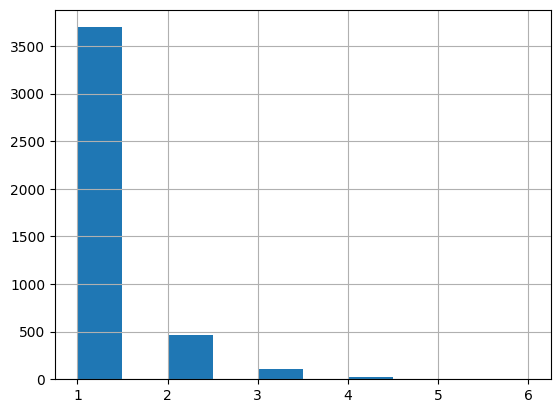

In [47]:
df_parcelas["102_coordenada_x_(utm)"].value_counts().hist()